In [1]:
%config Completer.use_jedi = False
%matplotlib notebook
%matplotlib inline
from scipy.io import mmread
import numpy as np
import matplotlib.pyplot as plt
import glob
from os import listdir
from os.path import isfile, join

starter = "matrix"+"\t"+"nr_rows"+"\t"+"nr_cols"+"\t"+"nr_nnzs"+"\t"+"density"+"\t"+"nnz-r-min"+"\t"+"nnz-r-max"+"\t"+"nnz-r-avg"+"\t"+"nnz-r-std"+"\t"+"nnz-c-min"+"\t"+"nnz-c-max"+"\t"+"nnz-c-avg"+"\t"+"nnz-c-std"+"\t"+"bw-min"+"\t"+"bw-max"+"\t"+"bw-avg"+"\t"+"bw-std"+"\t"+"sc-min"+"\t"+"sc-max"+"\t"+"sc-avg"+"\t"+"sc-std"+"\t"+"ng-min"+"\t"+"ng-max"+"\t"+"ng-avg"+"\t"+"ng-std"+"\t"+"dis-min"+"\t"+"dis-max"+"\t"+"dis-avg"+"\t"+"dis-std"+"\t"+"cl-min"+"\t"+"cl-max"+"\t"+"cl-avg"+"\t"+"cl-std"+"\n"
def retrieve_files(mypath):
    mtx_files = [mypath+f for f in listdir(mypath) if (".mtx" in join(mypath, f) and isfile(join(mypath, f)))]
    return mtx_files

In [2]:
def ngroups_and_dis_calc(row_ptr, col_ind, nnz_per_row):
    ngroups = []
    dis = []
    for i in range(len(row_ptr)-1):
        if(nnz_per_row[i]>0):
            curr_ng = 1
            prev = col_ind[row_ptr[i]]
            tmp_dis = []
            for j in range(row_ptr[i], row_ptr[i+1]):
                if(col_ind[j] > prev+1): # means we need to increase ngroups. in addition, keep in tmp_dis the new distance between the groups
                    curr_ng+=1
                    tmp_dis.append(col_ind[j]-prev)
                prev = col_ind[j]
            ngroups.append(curr_ng)
            dis.append(sum(tmp_dis)/len(tmp_dis) if(len(tmp_dis)>0) else 0)
        else:
            ngroups.append(0)
            dis.append(0)
    ngroups = np.asarray(ngroups)
    dis = np.asarray(dis)
    return ngroups,dis

In [5]:


# def mmread_fun2(filename, plot_it=False):
filename = "/mnt/various/SpMV-Research/validation_matrices/pdb1HYS.sorted.mtx"
plot_it = True    
spm_coo = mmread(filename)
filename = filename.split("/")[-1]

nr_rows = spm_coo.get_shape()[0]
nr_cols = spm_coo.get_shape()[1]
nr_nnzs = spm_coo.getnnz()
spm = spm_coo.tocsr()
row_ptr = spm.indptr
col_ind = spm.indices
values = spm.data

mem_footprint = round((row_ptr.nbytes + col_ind.nbytes + values.nbytes)/(1024*1024),3)
print(filename, ":\tdimensions", spm_coo.get_shape(), "/ nnz", spm_coo.getnnz(),"/ mem footprint",mem_footprint,'MB (CSR)')

nnz_per_row = np.ediff1d(row_ptr)
bandwidth2   = np.asarray([(col_ind[row_ptr[i+1]-1]-col_ind[row_ptr[i]]) if nnz_per_row[i]>0 else 0 for i in range(len(row_ptr)-1)])

pdb1HYS.sorted.mtx :	dimensions (36417, 36417) / nnz 4344765 / mem footprint 49.861 MB (CSR)


In [6]:
import numpy as np
import pandas as pd
import seaborn as sns
from fitter import Fitter, get_common_distributions, get_distributions

204
18
BADD 188
nnz-row : min = 18 max = 204 nr_bins = 188


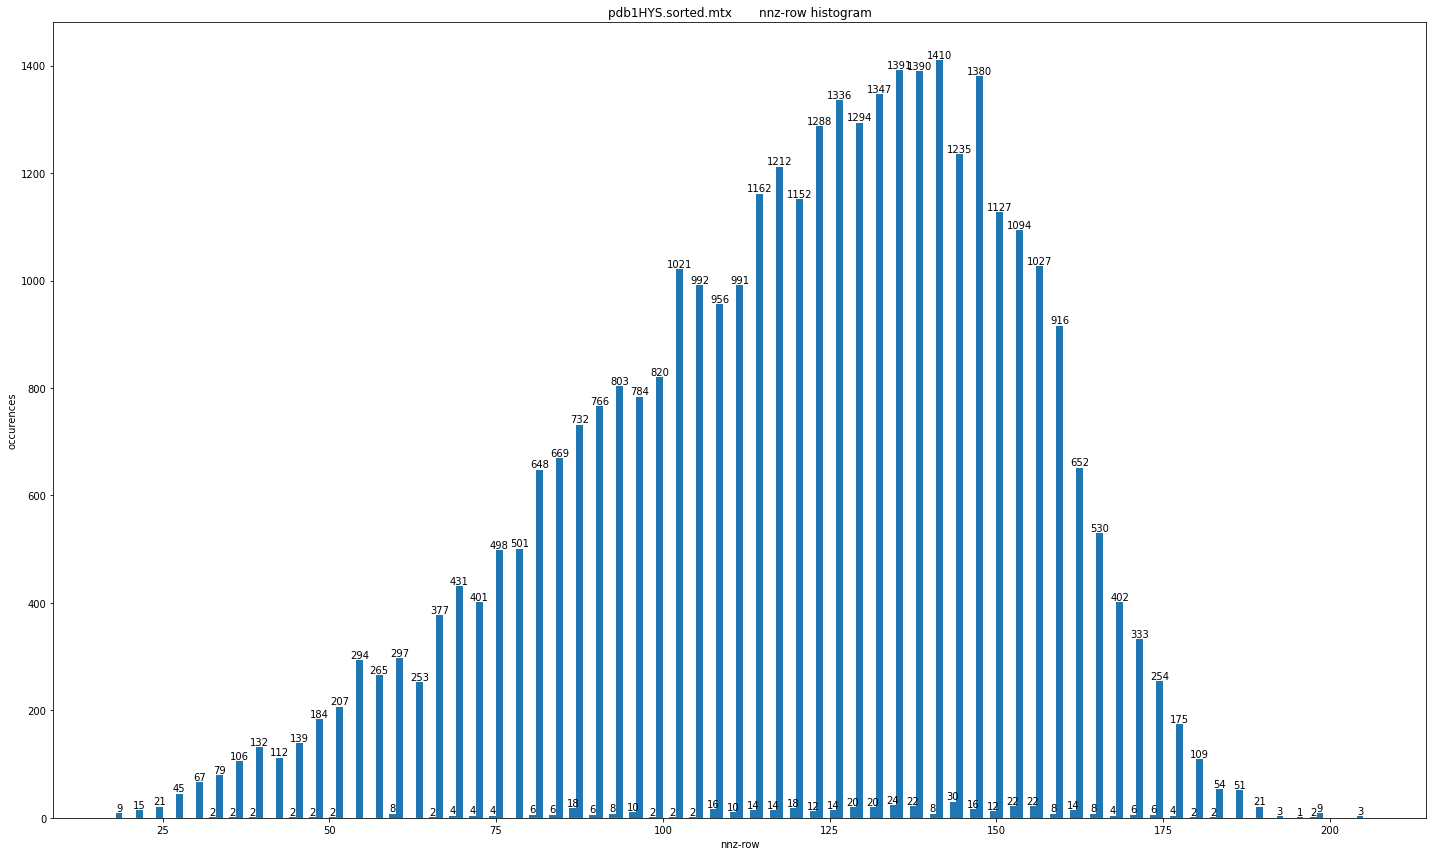

[   9    0    0   15    0    0   21    0    0   45    0    0   67    0
    2   79    0    2  106    0    2  132    0    0  112    0    2  139
    0    2  184    0    2  207    0    0  294    0    0  265    0    8
  297    0    0  253    0    2  377    0    4  431    0    4  401    0
    4  498    0    0  501    0    6  648    0    6  669    0   18  732
    0    6  766    0    8  803    0   10  784    0    2  820    0    2
 1021    0    2  992    0   16  956    0   10  991    0   14 1162    0
   14 1212    0   18 1152    0   12 1288    0   14 1336    0   20 1294
    0   20 1347    0   24 1391    0   22 1390    0    8 1410    0   30
 1235    0   16 1380    0   12 1127    0   22 1094    0   22 1027    0
    8  916    0   14  652    0    8  530    0    4  402    0    6  333
    0    6  254    0    4  175    0    2  109    0    2   54    0    0
   51    0    0   21    0    0    3    0    0    1    0    2    9    0
    0    0    0    0    3]


In [7]:
def plot_histogram(vector, name):
    threshold = 500
    print(max(vector))
    print(min(vector))
    if((max(vector)-min(vector)) > threshold):
        step = (max(vector)+2 - min(vector))//threshold
        bins_range = range(min(vector), max(vector)+2,step)
        print("GOOD", len(list(bins_range)))
    else:
        bins_range = range(min(vector), max(vector)+2,1)
        print("BADD", len(list(bins_range)))

    vector_hist, bin_edges_r = np.histogram(vector, bins=bins_range)
    print(name,": min =",min(vector), "max =",max(vector), "nr_bins =",len(list(bins_range)))
#         print("bin_edges_r", bin_edges_r[:-1])
#         print(name+"_hist", vector_hist)

    # plot histogram of nonzeros per row separately
    fig,ax = plt.subplots(1,1)
    fig.set_size_inches(20,12)
    ax.hist(vector, bins=bins_range)
    ax.set_title(filename + "       " + name + " histogram")
    ax.set_xlabel(name)
    ax.set_ylabel("occurences")
    # Make some labels.
    rects = ax.patches
    labels = [str(vector_hist[i]) if vector_hist[i]>0 else "" for i in range(len(rects))]
    for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width() / 2, height+0.01, label,ha='center', va='bottom')        
    plt.tight_layout()
#     plt.savefig("/home/pmpakos/sparse_matrix_features/histograms/"+filename.replace(".mtx","_histogram_"+name+".jpg"),transparent=False, dpi=150)
    plt.pause(0.05)
    return vector_hist, bin_edges_r

nnzr_hist, nnzr_bin_edges_r = plot_histogram(nnz_per_row, "nnz-row")
print(nnzr_hist)
# bw_hist,   bw_bin_edges_r   = plot_histogram(bandwidth2,  "bandwidth")

{'burr': {'c': 20.544131359766553,
  'd': 0.14858129891985267,
  'loc': -0.6446288456225413,
  'scale': 157.59701616180791}}

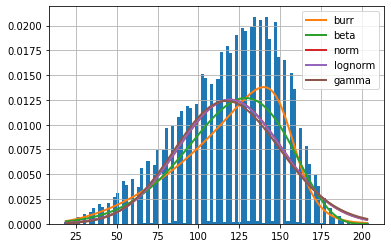

In [8]:
f = Fitter(nnz_per_row,
           distributions=['gamma',
                          'lognorm',
                          "beta",
                          "burr",
                          "norm"])
f.fit()
f.summary()
f.get_best(method = 'sumsquare_error')


In [9]:
f.fitted_param["burr"]

(20.544131359766553,
 0.14858129891985267,
 -0.6446288456225413,
 157.59701616180791)

In [10]:
print(get_common_distributions())
mu, sigma = 0, 0.1 # mean and standard deviation
data = np.random.normal(mu, sigma, 10000)data

['cauchy',
 'chi2',
 'expon',
 'exponpow',
 'gamma',
 'lognorm',
 'norm',
 'powerlaw',
 'rayleigh',
 'uniform']

In [11]:
import scipy.stats as st
def get_best_distribution(data):
    dist_names = ["cauchy", "chi2", "exponpow", "lognorm", "powerlaw", "rayleigh", ""
                  "norm", "exponweib", "weibull_max", "weibull_min", "pareto", "genextreme"]
    dist_results = []
    params = {}
    for dist_name in dist_names:
        dist = getattr(st, dist_name)
        param = dist.fit(data)

        params[dist_name] = param
        # Applying the Kolmogorov-Smirnov test
        D, p = st.kstest(data, dist_name, args=param)
        print("p value for "+dist_name+" = "+str(p))
        dist_results.append((dist_name, p))

    # select the best fitted distribution
    best_dist, best_p = (max(dist_results, key=lambda item: item[1]))
    # store the name of the best fit and its p value

    print("Best fitting distribution: "+str(best_dist))
    print("Best p value: "+ str(best_p))
    print("Parameters for the best fit: "+ str(params[best_dist]))

    return best_dist, best_p, params[best_dist]

get_best_distribution(nnz_per_row)

p value for norm = 4.580388450723298e-164
p value for exponweib = 3.4245791684318055e-221
p value for weibull_max = 0.0
p value for weibull_min = 1.0561508286755555e-47
p value for pareto = 0.0
p value for genextreme = 5.159190185945819e-102
Best fitting distribution: weibull_min
Best p value: 1.0561508286755555e-47
Parameters for the best fit: (8.905328611594719, -115.91745371857697, 248.71744374261345)


('weibull_min',
 1.0561508286755555e-47,
 (8.905328611594719, -115.91745371857697, 248.71744374261345))

In [ ]:
filenames = [
    "/mnt/various/SpMV-Research/validation_matrices/bbmat.sorted.mtx",
    "/mnt/various/SpMV-Research/validation_matrices/bone010.sorted.mtx",
    "/mnt/various/SpMV-Research/validation_matrices/cage15.sorted.mtx",
    "/mnt/various/SpMV-Research/validation_matrices/cant.sorted.mtx",
    "/mnt/various/SpMV-Research/validation_matrices/Chebyshev4.sorted.mtx",
    "/mnt/various/SpMV-Research/validation_matrices/circuit5M.sorted.mtx",
    "/mnt/various/SpMV-Research/validation_matrices/conf5_4-8x8-15.real.mtx",
    "/mnt/various/SpMV-Research/validation_matrices/consph.sorted.mtx",
    "/mnt/various/SpMV-Research/validation_matrices/cop20k_A.sorted.mtx",
    "/mnt/various/SpMV-Research/validation_matrices/crankseg_2.sorted.mtx",
    "/mnt/various/SpMV-Research/validation_matrices/eu-2005.sorted.mtx",
    "/mnt/various/SpMV-Research/validation_matrices/Ga41As41H72.sorted.mtx",
    "/mnt/various/SpMV-Research/validation_matrices/in-2004.sorted.mtx",
    "/mnt/various/SpMV-Research/validation_matrices/ldoor.sorted.mtx",
    "/mnt/various/SpMV-Research/validation_matrices/mac_econ_fwd500.sorted.mtx",
    "/mnt/various/SpMV-Research/validation_matrices/mc2depi.real.mtx",
    "/mnt/various/SpMV-Research/validation_matrices/mip1.sorted.mtx",
    "/mnt/various/SpMV-Research/validation_matrices/pdb1HYS.sorted.mtx",
    "/mnt/various/SpMV-Research/validation_matrices/PR02R.sorted.mtx",
    "/mnt/various/SpMV-Research/validation_matrices/pwtk.sorted.mtx",
    "/mnt/various/SpMV-Research/validation_matrices/raefsky3.sorted.mtx",
    "/mnt/various/SpMV-Research/validation_matrices/rail4284.real.mtx",
    "/mnt/various/SpMV-Research/validation_matrices/rajat31.sorted.mtx",
    "/mnt/various/SpMV-Research/validation_matrices/rma10.sorted.mtx",
    "/mnt/various/SpMV-Research/validation_matrices/scircuit.sorted.mtx",
    "/mnt/various/SpMV-Research/validation_matrices/shipsec1.sorted.mtx",
    "/mnt/various/SpMV-Research/validation_matrices/Si41Ge41H72.sorted.mtx",
    "/mnt/various/SpMV-Research/validation_matrices/TSOPF_RS_b300_c3.sorted.mtx",
    "/mnt/various/SpMV-Research/validation_matrices/TSOPF_RS_b2383.sorted.mtx",
    "/mnt/various/SpMV-Research/validation_matrices/webbase-1M.sorted.mtx",
    "/mnt/various/SpMV-Research/validation_matrices/wikipedia-20051105.sorted.mtx",
]

plot_it = True

stats_list = []
plot_it = True
for filename in filenames:
    print("------")
    line = mmread_fun2(filename, plot_it)

---
# MATRIX FEATURE EXTRACTION
### features
- **nnz/row** : simple
- **nnz/col** : simple
- **bandwidth** : column distance between the first and last nonzero element of each row (normalized by number of columns)
- **scattering** : how nonzeros are scattered within each row (how irregular the accesses to the right hand-side vector will be)
- **ngroups** : number of groups formed by consecutive elements of each row
- **dis** : average distance between each ngroup of each row
- **clustering** : how clustered nonzero groups are within each row

In [ ]:
def mmread_fun(filename, plot_it=False):
    spm_coo = mmread(filename)
    filename = filename.split("/")[-1]

    nr_rows = spm_coo.get_shape()[0]
    nr_cols = spm_coo.get_shape()[1]
    nr_nnzs = spm_coo.getnnz()
    spm = spm_coo.tocsr()
    row_ptr = spm.indptr
    col_ind = spm.indices
    values = spm.data

    mem_footprint = round((row_ptr.nbytes + col_ind.nbytes + values.nbytes)/(1024*1024),3)
    print(filename, ":\tdimensions", spm_coo.get_shape(), "/ nnz", spm_coo.getnnz(),"/ mem footprint",mem_footprint,'MB (CSR)')

    spm_csc = spm_coo.tocsc()
    col_ptr = spm_csc.indptr
    
    # simple, just keep #nnzs of each row and each column separately
    nnz_per_row = np.ediff1d(row_ptr)    
    nnz_per_col = np.ediff1d(col_ptr)
        
    # the column distance between the first and last nonzero element of each row (normalized by number of columns)
    bandwidth   = np.asarray([(col_ind[row_ptr[i+1]-1]-col_ind[row_ptr[i]])/nr_cols if nnz_per_row[i]>0 else 0 for i in range(len(row_ptr)-1)])
    
    # how nonzeros are scattered within each row (how irregular the accesses to the right hand-side vector will be)
    scatter     = np.asarray([(nnz_per_row[i]/(col_ind[row_ptr[i+1]-1]-col_ind[row_ptr[i]])) if (nnz_per_row[i]>0 and (col_ind[row_ptr[i+1]-1]-col_ind[row_ptr[i]])>0) else 0 for i in range(len(row_ptr)-1)])

    # ngroups : number of groups formed by consecutive elements of each row
    # dis : average distance between each ngroup of each row
    ngroups,dis = ngroups_and_dis_calc(row_ptr, col_ind, nnz_per_row)

    # how clustered nonzero groups are within each row
    clustering  = np.asarray([(ngroups[i]/nnz_per_row[i]) if (nnz_per_row[i]>0) else 0 for i in range(len(ngroups))])

    if(plot_it == True):
        fig, axs = plt.subplots(5,2)
        fig.set_size_inches(15,20)
        img_filename = []

        if("sparse_" in filename):
            img_path = "/home/pmpakos/sparse_matrices/"
            img_filename = glob.glob(img_path + "/**/"+filename.replace(".mtx",".png").replace("sparse","fig"), recursive = True)
            if ("_x" in filename):
                ext = "random_matrices_x/"
            elif ("_y" in filename):
                ext = "random_matrices_y/"
            else:
                ext = "./"
        elif("00K.mtx" in filename):
            img_path = "/mnt/various/exafoam_matrices"
            img_filename = glob.glob(img_path + "/**/"+filename.replace(".mtx",".png"), recursive = True)
            ext = "exafoam_matrices/"
        else:
            # img_path = "/home/pmpakos/without_and_with_rcm"
            # img_filename = glob.glob(img_path + "/**/"+filename.replace(".mtx",".png"), recursive = True)
            img_filename = ["/mnt/various/SpMV-Research/validation_matrices/images/" + filename.split(".")[0]+".png"]
        ext = "./"
        if(len(img_filename)>0): # only if png file is found, else show nothing in image plot
            im = plt.imread(img_filename[0])

            axs[0,0].imshow(im)
            axs[0,0].set_title(filename)
            axs[0,0].set_axis_off()

        axs[1,0].plot(nnz_per_row)
        axs[1,0].set_title("nnz_per_row")

        axs[1,1].plot(nnz_per_col)
        axs[1,1].set_title("nnz_per_col")

        axs[2,0].plot(bandwidth)
        axs[2,0].set_title("bandwidth")

        axs[2,1].plot(scatter)
        axs[2,1].set_title("scatter")

        axs[3,0].plot(ngroups)
        axs[3,0].set_title("ngroups")

        axs[3,1].plot(dis)
        axs[3,1].set_title("dis")

        axs[4,0].plot(clustering)
        axs[4,0].set_title("clustering")
        
        plt.tight_layout()
        plt.savefig("/mnt/various/SpMV-Research/validation_matrices/features/"+filename.replace(".mtx","_features.jpg"),transparent=False, dpi=150)
        plt.pause(0.05)
    
    return spm, nnz_per_row, nnz_per_col, bandwidth, scatter, ngroups, dis, clustering

In [ ]:
def return_stats(filename, spm,nnz_per_row, nnz_per_col, bandwidth, scatter, ngroups, dis, clustering):
    filename = filename.split("/")[-1]
    nr_rows = spm.get_shape()[0]
    nr_cols = spm.get_shape()[1]
    nr_nnzs = spm.getnnz()
    density = nr_nnzs / (nr_rows*nr_cols) * 100
    
    min_nnz_per_row = np.min(nnz_per_row)
    max_nnz_per_row = np.max(nnz_per_row)
    avg_nnz_per_row = np.mean(nnz_per_row)
    std_nnz_per_row = np.std(nnz_per_row)

    min_nnz_per_col = np.min(nnz_per_col)
    max_nnz_per_col = np.max(nnz_per_col)
    avg_nnz_per_col = np.mean(nnz_per_col)
    std_nnz_per_col = np.std(nnz_per_col)
    
    min_bandwidth = np.min(bandwidth)
    max_bandwidth = np.max(bandwidth)
    avg_bandwidth = np.mean(bandwidth)
    std_bandwidth = np.std(bandwidth)
    
    min_scatter = np.min(scatter)
    max_scatter = np.max(scatter)
    avg_scatter = np.mean(scatter)
    std_scatter = np.std(scatter)
    
    min_ngroups = np.min(ngroups)
    max_ngroups = np.max(ngroups)
    avg_ngroups = np.mean(ngroups)
    std_ngroups = np.std(ngroups)
    
    min_dis = np.min(dis)
    max_dis = np.max(dis)
    avg_dis = np.mean(dis)
    std_dis = np.std(dis)
    
    min_clustering = np.min(clustering)
    max_clustering = np.max(clustering)
    avg_clustering = np.mean(clustering)
    std_clustering = np.std(clustering)

    stats = [nr_rows,nr_cols,nr_nnzs,density,min_nnz_per_row,max_nnz_per_row,avg_nnz_per_row,std_nnz_per_row,min_nnz_per_col,max_nnz_per_col,avg_nnz_per_col,std_nnz_per_col,min_bandwidth,max_bandwidth,avg_bandwidth,std_bandwidth,min_scatter,max_scatter,avg_scatter,std_scatter,min_ngroups,max_ngroups,avg_ngroups,std_ngroups,min_dis,max_dis,avg_dis,std_dis,min_clustering,max_clustering,avg_clustering,std_clustering]
    stats = "\t".join((str(x) for x in stats))
    line = filename.replace(".mtx","") + "\t" + stats
    return line
    
def stats_extraction(filename, plot_it):
#     spm, nnz_per_row, nnz_per_col, bandwidth, scatter, ngroups, dis, clustering, nnz_r_hist, bin_edges_r = mmread_fun(filename, plot_it)
    spm, nnz_per_row, nnz_per_col, bandwidth, scatter, ngroups, dis, clustering = mmread_fun(filename, plot_it)
    line = return_stats(filename, spm, nnz_per_row, nnz_per_col, bandwidth, scatter, ngroups, dis, clustering)
    
    return line #, nnz_r_hist, bin_edges_r, nnz_per_row

---

In [ ]:
filenames = [
    "/mnt/various/SpMV-Research/validation_matrices/cop20k_A.sorted.mtx",
    "/mnt/various/SpMV-Research/validation_matrices/scircuit.sorted.mtx",
    "/mnt/various/SpMV-Research/validation_matrices/mac_econ_fwd500.sorted.mtx",
    "/mnt/various/SpMV-Research/validation_matrices/mc2depi.real.mtx",
    "/mnt/various/SpMV-Research/validation_matrices/raefsky3.sorted.mtx",
    "/mnt/various/SpMV-Research/validation_matrices/bbmat.sorted.mtx",
    "/mnt/various/SpMV-Research/validation_matrices/pdb1HYS.sorted.mtx",
    "/mnt/various/SpMV-Research/validation_matrices/conf5_4-8x8-15.real.mtx",
    "/mnt/various/SpMV-Research/validation_matrices/cant.sorted.mtx",
    "/mnt/various/SpMV-Research/validation_matrices/rma10.sorted.mtx",
    "/mnt/various/SpMV-Research/validation_matrices/mip1.sorted.mtx",
    "/mnt/various/SpMV-Research/validation_matrices/webbase-1M.sorted.mtx",
    "/mnt/various/SpMV-Research/validation_matrices/consph.sorted.mtx",
    "/mnt/various/SpMV-Research/validation_matrices/shipsec1.sorted.mtx",
    "/mnt/various/SpMV-Research/validation_matrices/TSOPF_RS_b300_c3.sorted.mtx",
    "/mnt/various/SpMV-Research/validation_matrices/crankseg_2.sorted.mtx",
    "/mnt/various/SpMV-Research/validation_matrices/pwtk.sorted.mtx",
    "/mnt/various/SpMV-Research/validation_matrices/rail4284.real.mtx",
    "/mnt/various/SpMV-Research/validation_matrices/Chebyshev4.sorted.mtx",
    "/mnt/various/SpMV-Research/validation_matrices/in-2004.sorted.mtx",
    "/mnt/various/SpMV-Research/validation_matrices/Si41Ge41H72.sorted.mtx",
    "/mnt/various/SpMV-Research/validation_matrices/PR02R.sorted.mtx",
    "/mnt/various/SpMV-Research/validation_matrices/eu-2005.sorted.mtx",
    "/mnt/various/SpMV-Research/validation_matrices/wikipedia-20051105.sorted.mtx",
    "/mnt/various/SpMV-Research/validation_matrices/Ga41As41H72.sorted.mtx",
    "/mnt/various/SpMV-Research/validation_matrices/TSOPF_RS_b2383.sorted.mtx",
    "/mnt/various/SpMV-Research/validation_matrices/rajat31.sorted.mtx",
    "/mnt/various/SpMV-Research/validation_matrices/ldoor.sorted.mtx",
    "/mnt/various/SpMV-Research/validation_matrices/bone010.sorted.mtx",
    "/mnt/various/SpMV-Research/validation_matrices/circuit5M.sorted.mtx",
    "/mnt/various/SpMV-Research/validation_matrices/cage15.sorted.mtx",
]

plot_it = True

stats_list = []
plot_it = True
for filename in filenames:
    line = stats_extraction(filename, plot_it)
    stats_list.append(line)

file = open("/mnt/various/SpMV-Research/validation_matrices/features/validation_matrices_features.txt","w")
for line in stats_list:
    file.write(line+"\n")
file.close()

---
# RCM (Reverse Cuthill-McKee) reordering

In [ ]:
filenames = [
    "/mnt/various/athena_ppopp_matrices/filtered/Ronis/xenon2.mtx",
    "/mnt/various/athena_ppopp_matrices/filtered/PARSEC/Si41Ge41H72.mtx",
    "/mnt/various/athena_ppopp_matrices/filtered/Dziekonski/dielFilterV3real.mtx",

    "/mnt/various/athena_ppopp_matrices/filtered/Botonakis/thermomech_dK.mtx",
    "/mnt/various/athena_ppopp_matrices/filtered/Gleich/wikipedia-20051105.mtx",
    "/mnt/various/athena_ppopp_matrices/filtered/SNAP/soc-LiveJournal1.mtx",

    "/mnt/various/athena_ppopp_matrices/filtered/Sandia/ASIC_680k.mtx",
    "/mnt/various/athena_ppopp_matrices/filtered/Freescale/circuit5M.mtx",
    "/mnt/various/athena_ppopp_matrices/filtered/LAW/in-2004.mtx",

    "/mnt/various/exafoam_matrices/100K.mtx",
    "/mnt/various/exafoam_matrices/600K.mtx"]

plot_it = True

stats_list = []
plot_it = True
for filename in filenames:
    line = stats_extraction(filename, plot_it)
    stats_list.append(line)

file = open("targeted_matrices_features.txt","w")
for line in stats_list:
    file.write(line+"\n")
file.close()

In [ ]:
filenames=[
    "/mnt/various/athena_ppopp_matrices/filtered/Ronis/xenon2_rcm.mtx",
    "/mnt/various/athena_ppopp_matrices/filtered/PARSEC/Si41Ge41H72_rcm.mtx",
    "/mnt/various/athena_ppopp_matrices/filtered/Dziekonski/dielFilterV3real_rcm.mtx",
    
    "/mnt/various/athena_ppopp_matrices/filtered/Botonakis/thermomech_dK_rcm.mtx",
    "/mnt/various/athena_ppopp_matrices/filtered/Gleich/wikipedia-20051105_rcm.mtx",
    "/mnt/various/athena_ppopp_matrices/filtered/SNAP/soc-LiveJournal1_rcm.mtx",
    
    "/mnt/various/athena_ppopp_matrices/filtered/Sandia/ASIC_680k_rcm.mtx",
    "/mnt/various/athena_ppopp_matrices/filtered/LAW/in-2004_rcm.mtx",
    "/mnt/various/athena_ppopp_matrices/filtered/Freescale/circuit5M_rcm.mtx",
    
    "/mnt/various/exafoam_matrices/100K_rcm.mtx",
    "/mnt/various/exafoam_matrices/600K_rcm.mtx"]

plot_it = True

stats_list = []
plot_it = True
for filename in filenames:
    line = stats_extraction(filename, plot_it)
    stats_list.append(line)

file = open("targeted_matrices_rcm_features.txt","w")
for line in stats_list:
    file.write(line+"\n")
file.close()

---
# dgal partitioning

In [ ]:
# dgal partitioning
filenames=[
    "/mnt/various/athena_ppopp_matrices/filtered/Freescale/circuit5M_sorted_1.mtx",
    "/mnt/various/athena_ppopp_matrices/filtered/Freescale/circuit5M_sorted_2.mtx",
    "/mnt/various/athena_ppopp_matrices/filtered/Freescale/circuit5M_sorted_3.mtx",
    "/mnt/various/athena_ppopp_matrices/filtered/Freescale/circuit5M_sorted_4.mtx",

    "/mnt/various/athena_ppopp_matrices/filtered/Dziekonski/dielFilterV3real_sorted_1.mtx",
    "/mnt/various/athena_ppopp_matrices/filtered/Dziekonski/dielFilterV3real_sorted_2.mtx",
    "/mnt/various/athena_ppopp_matrices/filtered/Dziekonski/dielFilterV3real_sorted_3.mtx",
    "/mnt/various/athena_ppopp_matrices/filtered/Dziekonski/dielFilterV3real_sorted_4.mtx",

    "/mnt/various/athena_ppopp_matrices/filtered/SNAP/soc-LiveJournal1_sorted_1.mtx",
    "/mnt/various/athena_ppopp_matrices/filtered/SNAP/soc-LiveJournal1_sorted_2.mtx",
    "/mnt/various/athena_ppopp_matrices/filtered/SNAP/soc-LiveJournal1_sorted_3.mtx",
    "/mnt/various/athena_ppopp_matrices/filtered/SNAP/soc-LiveJournal1_sorted_4.mtx",

    "/mnt/various/athena_ppopp_matrices/filtered/Gleich/wikipedia-20051105_sorted_1.mtx",
    "/mnt/various/athena_ppopp_matrices/filtered/Gleich/wikipedia-20051105_sorted_2.mtx",
    "/mnt/various/athena_ppopp_matrices/filtered/Gleich/wikipedia-20051105_sorted_3.mtx",
    "/mnt/various/athena_ppopp_matrices/filtered/Gleich/wikipedia-20051105_sorted_4.mtx"
]

plot_it = True

stats_list = []
plot_it = True
for filename in filenames:
    line = stats_extraction(filename, plot_it)
    stats_list.append(line)

file = open("targeted_large_matrices_dgal_partitioning.txt","w")
for line in stats_list:
    file.write(line+"\n")
file.close()

In [ ]:
# dgal partitioning
filenames=[
    "/mnt/various/athena_ppopp_matrices/filtered/dgal_partitioning/artificial_gamma_distribution_soc-LiveJournal1_sorted_4_3953914_3953914_16582299_random_seed_10.mtx",
    "/mnt/various/athena_ppopp_matrices/filtered/dgal_partitioning/artificial_gamma_distribution_soc-LiveJournal1_sorted_4_3953914_3953914_16582299_diagonal_df0.5_seed_10.mtx",
    "/mnt/various/athena_ppopp_matrices/filtered/dgal_partitioning/artificial_gamma_distribution_soc-LiveJournal1_sorted_4_3953914_3953914_16582299_diagonal_df0.05_seed_10.mtx",
    "/mnt/various/athena_ppopp_matrices/filtered/dgal_partitioning/artificial_gamma_distribution_soc-LiveJournal1_sorted_4_3953914_3953914_16582299_diagonal_df0.005_seed_10.mtx",    
    
    "/mnt/various/athena_ppopp_matrices/filtered/dgal_partitioning/artificial_normal_distribution_dielFilterV3real_sorted_4_636608_636608_19688400_random_seed_29.mtx",
    "/mnt/various/athena_ppopp_matrices/filtered/dgal_partitioning/artificial_normal_distribution_dielFilterV3real_sorted_4_636608_636608_19688400_diagonal_df0.5_seed_29.mtx",
    "/mnt/various/athena_ppopp_matrices/filtered/dgal_partitioning/artificial_normal_distribution_dielFilterV3real_sorted_4_636608_636608_19688400_diagonal_df0.05_seed_29.mtx",
    "/mnt/various/athena_ppopp_matrices/filtered/dgal_partitioning/artificial_normal_distribution_dielFilterV3real_sorted_4_636608_636608_19688400_diagonal_df0.005_seed_29.mtx",
]

stats_list = []
plot_it = False
for filename in filenames:
    line = stats_extraction(filename, plot_it)
    stats_list.append(line)

file = open("targeted_large_matrices_dgal_partitioning_artificial_digital_twins.txt","w")
for line in stats_list:
    file.write(line+"\n")
file.close()